## Import modules

In [1]:
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
import gc 
from IPython.display import HTML
import warnings
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon, Point, LineString
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn import metrics
import sqlalchemy
import psycopg2
import os
import subprocess
from scipy.spatial import ConvexHull
# from scipy.spatial import Delaunay
warnings.filterwarnings("ignore")
%matplotlib inline  

## Setup database connection

In [2]:
USER = 'harry'
PASSWORD = 'harry'
enginestring = 'postgresql://{}:{}@localhost:5433/tweets'.format(USER, PASSWORD)
engine = sqlalchemy.create_engine(enginestring)

conn = psycopg2.connect("dbname=tweets user=harry host=localhost port=5433 password='harry'")
cur = conn.cursor()
conn.commit()

In [2]:
with open("tweets_1M.json",'r') as f:
    tweets=json.load(f)

In [3]:
df = pd.DataFrame(tweets)
print (len(df),"rows of data")
df.head()

1000000 rows of data


,user_id,text,timeStamp,lat,lng,id
0,224874450,@Tanner_Cortez hey checkout the website: http:...,Wed Sep 11 04:38:08 +0000 2013,37.446100,-121.883557,377652254096228352
1,312179473,@Lennayy7 😪,Wed Sep 11 04:38:08 +0000 2013,34.087406,-117.462604,377652255346159616
2,54351774,i laugh a lot with that line,Wed Sep 11 04:38:10 +0000 2013,37.356131,-121.842867,377652262325456897
3,343219606,sons of anarchy is back on woop woop,Wed Sep 11 04:38:11 +0000 2013,37.364664,-122.009629,377652264682655744
4,1569395935,Drinking a Fresh Squeezed IPA by @deschutesbee...,Wed Sep 11 04:38:12 +0000 2013,37.382600,-121.995000,377652271116722176


## Convert to state plane coordinates

In [4]:
df['lat_conv'] = (df.lat - 32)*89700 # convert to meters with origin at 32d N (1d lat = 89.7km)
df['lng_conv'] = (df.lng + 126)*112700 # convert to meters with origin at 126d W (1d lng = 112.7km)
df = df.assign(crds=df[['lat_conv', 'lng_conv']].values.tolist())
# # define the number of kilometers in one radian
# kms_per_radian = 6371.0088
# # define epsilon as 1.5 kilometers, converted to radians for use by haversine
# EPSILON = 1.5 / kms_per_radian

## Run Mini-Batch KMeans to divide data into spatial clusters

In [5]:
n = 10 # set the number of clusters to split the data into
def runMBKmeans(df):
    # RUNNING MINIBATCH KMEANS ON ENTIRE SET 
#     print ('Beginning to run MiniBatch Kmeans.')
    ## initialize with MBK-means++, a good way to speed up convergence more than K-Means
    mbk_means = MiniBatchKMeans(init='k-means++', n_clusters=n, n_init=10, init_size = 3*n, verbose = 0) # set minibatch kmeans parameters
    mbk_means.fit(list(df.crds.values)) # run mini batch k means on the lat and lng coordinate data
    df['mbk_means_labels'] = mbk_means.labels_ # this is an array that indicates which cluster each tweet is in
    df_output = df
    mbk_means_cluster_centers = mbk_means.cluster_centers_ # this is an array that indicates which cluster each tweet is in
    df0 = pd.DataFrame()
    df0= pd.DataFrame(mbk_means_cluster_centers,columns = ['lat','lng'])
    df0 = pd.DataFrame(mbk_means_cluster_centers,columns = ['lat_centroid','lng_centroid'])
    df0['unique_tweeters'] = df.groupby('mbk_means_labels')['user_id'].nunique()
    df0['unique_tweets'] = df.groupby('mbk_means_labels')['mbk_means_labels'].count()
#     print ('Finished running Kmeans.')
    return df_output, df0

In [6]:
df,df0 = runMBKmeans(df)
df0['labels'] = np.arange(n)
df['db_labels'] = ""

## Running DBSCAN on each cluster generated by MiniBatch Kmeans

In [7]:
def runDBSCAN(df,EPSILON):
    coords = list(df.crds.values)
    db = DBSCAN(eps=EPSILON).fit(coords)
    db_labels = db.labels_ # create DBSCAN cluster labels generated for the cluster generated by MBKmeans
    db_labels_unique = np.unique(db_labels)
    k_DB = len(db_labels_unique)-1   #number of clusters detected with DBSCAN, subtract one because one cluster is noise (-1)    
    DB_noise = list(db_labels).count(-1) # these are tweets that DBScan determined to be noise
    df.db_labels = list(db.labels_)
#     print ('Number of sub-clusters detected is: ', k_DB)
#     print ('Noise tweet count is: ', DB_noise)
#     print ('Important (non-noise) tweet count is : ', len(df)-DB_noise)
    collected = gc.collect() 
    return df

In [8]:
clusters = np.arange(n)
EPSILON = 400 #meters
for cluster in clusters:
#     print ('________________________________________')
    start_time = time.time()
    df_cluster = df[df['mbk_means_labels']==cluster]
    if len(df_cluster)>1:
        df_cluster1 = runDBSCAN(df_cluster,EPSILON)
        df[df['mbk_means_labels']==cluster] = df_cluster1
        elapsed_time = time.time() - start_time
    else:
        next
    print('Cluster #', cluster, 'Run Time: ', round(elapsed_time,0), 'seconds')

Cluster # 0 Run Time:  13.0 seconds
Cluster # 1 Run Time:  5.0 seconds
Cluster # 2 Run Time:  2.0 seconds
Cluster # 3 Run Time:  1.0 seconds
Cluster # 4 Run Time:  6.0 seconds
Cluster # 5 Run Time:  2.0 seconds
Cluster # 6 Run Time:  29.0 seconds
Cluster # 7 Run Time:  2.0 seconds
Cluster # 8 Run Time:  2.0 seconds
Cluster # 9 Run Time:  7.0 seconds


## Removing points determined to be noise in DBSCAN (i.e. cluster labels of '-1')

In [9]:
df = df[df.db_labels!= -1]
print ('Rows of data reduced from 1000000 to' , str(len(df)) + ".")

Rows of data reduced from 1000000 to 985158.


## Create a unique cluster label that combines both kmeans and dbscan cluster labels

In [10]:
df['labels'] = (df.mbk_means_labels).astype(str) + '.' + (df.db_labels).astype(str)
num_of_clusters = len(df.groupby('labels').labels.nunique())
print (num_of_clusters , "clusters were found in the data.")

3545 clusters were found in the data.


## Write data to  psql / postgis database

In [12]:
df.to_sql('tweetpoints', engine, if_exists='replace')

In [13]:
cur.execute("SELECT AddGeometryColumn ('tweetpoints', 'location', 4326, 'POINT', 2);")
cur.execute("UPDATE tweetpoints SET location = ST_SetSRID (ST_Point(lng, lat), 4326);")
conn.commit()

## Create a new dataframe to hold cluster information

In [14]:
df1 = pd.DataFrame()
df1['label'] = df.groupby('labels').labels.nunique().index.values
df1['tweetcount'] =  df.groupby('labels').user_id.count().values
df1['usercount'] =  df.groupby('labels').user_id.nunique().values
df1 = df1.sort_values('tweetcount', ascending=False)

In [15]:
df1.head()

,label,tweetcount,usercount
2591,6.0,241859,27035
0,0.0,164483,9278
3343,9.0,85945,8091
1950,4.1,73890,3655
1949,4.0,41014,6676


## Filter out clusters that contain less than a thousand tweets in them

In [16]:
threshold = 250
df2 = df1[df1.tweetcount >= threshold]
df2 = df2[df2.usercount > 1] # remove clusters that consist of only one user account
print (len(df2), "clusters contain at least", threshold,"tweets.")

186 clusters contain at least 250 tweets.


## Investigate distribution of the number of tweets in each cluster

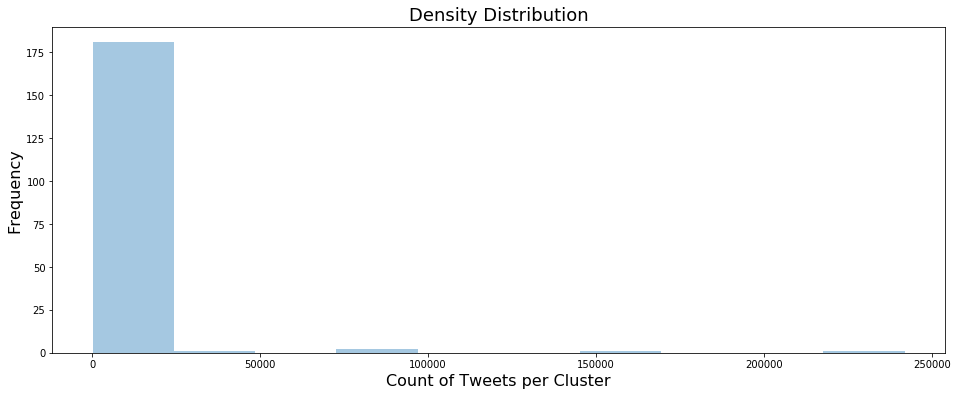

In [17]:
import seaborn as sns

for col in ['tweetcount']: #,'usercount']:
    plt.figure(figsize=(16, 6))
    sns.distplot(df2[col], kde=False, bins=10)
    plt.title('Density Distribution', fontsize=18)
    plt.xlabel('Count of Tweets per Cluster', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)

## Loop through labels to determin the convex hull (approximate perimeter) around each cluster

In [18]:
# for kmeans clusters
df0['geom'] = ""
for cluster in df0.labels:
    df3 = df[df.mbk_means_labels == cluster]
    points = [[float(lng), float(lat)] for lng, lat in zip(df3.lng, df3.lat)]
    multi_point = MultiPoint(points)
    convex = multi_point.convex_hull
    hull = str(convex)
    df0.loc[df0['labels'] == cluster, ['geom']] = hull

In [19]:
# for dbscan clusters
df2['geom'] = ""
for cluster in df2.label:
    df3 = df[df.labels == cluster]
    points = [[float(lng), float(lat)] for lng, lat in zip(df3.lng, df3.lat)]
    multi_point = MultiPoint(points)
    convex = multi_point.convex_hull
    hull = str(convex)
    df2.loc[df2['label'] == cluster, ['geom']] = hull

## Write the cluster dataframe to a psql/postgis

In [20]:
df0.to_sql('mbkmclusters', engine, if_exists='replace')

In [21]:
df2.to_sql('clusters', engine, if_exists='replace')

## Alter the psql/postgis clusters table to have spatial geometry 

In [22]:
cur.execute("SELECT AddGeometryColumn ('mbkmclusters', 'geometry', 4326, 'POLYGON', 2);")
cur.execute("UPDATE mbkmclusters SET geometry = ST_SetSRID(ST_GeomFromText(geom), 4326);")
cur.execute("ALTER TABLE mbkmclusters DROP COLUMN geom;")
conn.commit()

In [23]:
cur.execute("SELECT AddGeometryColumn ('clusters', 'geometry', 4326, 'POLYGON', 2);")
cur.execute("UPDATE clusters SET geometry = ST_SetSRID(ST_GeomFromText(geom), 4326);")
cur.execute("ALTER TABLE clusters DROP COLUMN geom;")
conn.commit()

In [24]:
conn.rollback() # use this command if error is given during query

## Load shapefile of counties

1) copy shapefile of counties

2) change directory to location of shapepile

3) in terminal: sudo -su postgres

4) in terminal: shp2pgsql -I -W "latin1" -s 4326 tl_2010_06_county10/tl_2010_06_county10.shp tl_2010_06_county10 | psql -d tweets

In [25]:
cur.execute("Select * FROM tl_2010_06_county10;")
colnames = [desc[0] for desc in cur.description]
print (colnames)

['gid', 'statefp10', 'countyfp10', 'countyns10', 'geoid10', 'name10', 'namelsad10', 'lsad10', 'classfp10', 'mtfcc10', 'csafp10', 'cbsafp10', 'metdivfp10', 'funcstat10', 'aland10', 'awater10', 'intptlat10', 'intptlon10', 'geom']


In [27]:
cur.execute("Select * FROM ca_census_data;")
colnames = [desc[0] for desc in cur.description]
print (colnames)

['index', 'geoid', 'sumlev', 'state', 'county', 'cbsa', 'csa', 'necta', 'cnecta', 'name', 'pop100', 'hu100', 'pop1002000', 'hu1002000', 'p001001', 'p0010012000']


In [28]:
cur.execute("Select * FROM clusters;")
colnames = [desc[0] for desc in cur.description]
print (colnames)

['index', 'label', 'tweetcount', 'usercount', 'geometry']


## Copy census population data per county into posgis table

In [29]:
ca_census_data = pd.read_csv('all_050_in_06.P1.csv')
colnames = [x.lower() for x in ca_census_data.columns.values] # convert column names to lowercase
ca_census_data.columns = colnames
ca_census_data.to_sql('ca_census_data', engine, if_exists='replace')
ca_census_data.head()

,geoid,sumlev,state,county,cbsa,csa,necta,cnecta,name,pop100,hu100,pop1002000,hu1002000,p001001,p0010012000
0,6001,50,6,1,41860,488,NaN,NaN,Alameda County,1510271,582549,1443741,540183,1510271,1443741
1,6003,50,6,3,99999,999,NaN,NaN,Alpine County,1175,1760,1208,1514,1175,1208
2,6005,50,6,5,99999,999,NaN,NaN,Amador County,38091,18032,35100,15035,38091,35100
3,6007,50,6,7,17020,999,NaN,NaN,Butte County,220000,95835,203171,85523,220000,203171
4,6009,50,6,9,99999,999,NaN,NaN,Calaveras County,45578,27925,40554,22946,45578,40554


## Population per county

In [30]:
sql = '''
SELECT name as county, pop100 AS population
FROM ca_census_data
ORDER BY pop100;'''

x = pd.read_sql_query(sql, con=conn)
x.head()

,county,population
0,Alpine County,1175
1,Sierra County,3240
2,Modoc County,9686
3,Trinity County,13786
4,Mono County,14202


## Number of tweets per county

In [31]:
sql = """
SELECT t1.namelsad10 AS county, COUNT(T2.id) AS tweetcount
FROM tl_2010_06_county10 T1,tweetpoints T2
WHERE ST_Contains(T1.geom,T2.location)
GROUP BY T1.namelsad10 
ORDER BY T1.namelsad10;
"""

y = pd.read_sql_query(sql, con=conn)
y.head()

,county,tweetcount
0,Alameda County,169909
1,Alpine County,7
2,Amador County,562
3,Butte County,3659
4,Calaveras County,72


## Tweets per capita in each county

#### Create postgis table

In [33]:
sql = """
DROP TABLE IF EXISTS tweetspercapita;
CREATE TABLE tweetspercapita AS
(SELECT t3.namelsad10 AS county, t3.x AS tweetcount, t4.pop100 AS population, ROUND(t3.x*100.0/t4.pop100,2) AS tweetspercapita, t5.geom
FROM
    (SELECT t1.namelsad10, CAST(COUNT(t2.id) AS NUMERIC) AS x
    FROM tl_2010_06_county10 t1,tweetpoints t2
    WHERE ST_Contains(t1.geom,t2.location)
    GROUP BY t1.namelsad10 
    ORDER BY t1.namelsad10) AS t3
    LEFT JOIN
        (SELECT name, pop100
        FROM ca_census_data
        ORDER BY pop100) AS t4
    ON t3.namelsad10 = t4.name
    LEFT JOIN
        (SELECT geom, namelsad10
        FROM tl_2010_06_county10) AS t5
    ON t4.name = t5.namelsad10);"""
cur.execute(sql)
conn.commit()

#### Create dataframe from query

In [62]:
sql = """
SELECT t3.namelsad10 AS county, t3.x AS tweetcount, t4.pop100 AS population, ROUND(t3.x*100.0/t4.pop100,2) AS tweetspercapita, t5.geom
FROM
    (SELECT t1.namelsad10, CAST(COUNT(t2.id) AS NUMERIC) AS x
    FROM tl_2010_06_county10 t1,tweetpoints t2
    WHERE ST_Contains(t1.geom,t2.location)
    GROUP BY t1.namelsad10 
    ORDER BY t1.namelsad10) AS t3
    LEFT JOIN
        (SELECT name, pop100
        FROM ca_census_data
        ORDER BY pop100) AS t4
    ON t3.namelsad10 = t4.name
    LEFT JOIN
        (SELECT geom, namelsad10
        FROM tl_2010_06_county10) AS t5
    ON t4.name = t5.namelsad10;"""

df4 = pd.read_sql_query(sql, con=conn)

#### Write the dataframe to a geojson file

In [82]:
gdf_counties = gpd.read_file("tl_2010_06_county10/tl_2010_06_county10.shp")
geometry = gdf_counties.geometry
gdf = gpd.GeoDataFrame(df4, geometry=geometry)
gdf.to_file('tweetspercapita.geojson', driver='GeoJSON')

## Chloropleth map of the number of tweets per capita by county

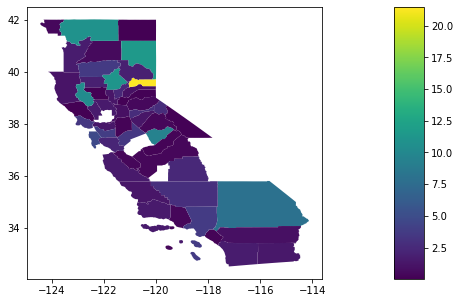

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(20, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=1)
gdf.plot(column='tweetspercapita', ax=ax, legend=True,cax=cax);